Deck quality analyzer (by Arseny Khakhalin). 

Forked from the general analysis script. This script assumes that the "Basic analysis" notebook was already run, and so both "basic_data" and "distances" CSV files are already saved.

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA, WAR
setName = 'WAR'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

# thisSet[list(thisSet.keys())[0]] # Full info for one card

Change the addresses below if you store data ini a different folder locally:

In [6]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv',
    'WAR': '../2019-04-29 WAR prerelease leadup.csv'
}

draftData = pd.read_csv('../'+dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

# draftData.head()
print('Loaded ', len(draftData['format']), " draft records.")

Loaded  61878  draft records.


In [7]:
# Read basic set data and card-to-card distances

df = pd.read_csv('basic_data_'+setName+'.csv')
df = df.set_index('name')

dist = np.genfromtxt('distances_'+setName+'.csv', delimiter=',')

df = df.loc[df.freq>0] # Remove cards that are formally in the set, but are actually never drafted

In [8]:
# Create a new df with a more inclusive color allocation (multis are counted as all colors)

df2 = df.copy()
colorLines = pd.DataFrame(
    { 'w': ['W' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'u': ['U' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'b': ['B' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'r': ['R' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'g': ['G' in thisSet[cardName]['colorIdentity'] for cardName in df2.index]},
             list(df2.index))
df2 = df2.join(colorLines)
#df2

In [9]:
# A tiny function that turns azorius_guildgate_2 to azorius_guildgate.
# Both df and carslist don't have these _2 cards, and so they aren't in the dist as well.
# Not sure why this error didn't come up earlier.

def fix_gates(cardName):
    if cardName[-2]=='_':
        return cardName[:-2]
    else:
        return cardName

In [103]:
# Constants for the main cycle below (no need to change them)

colorList = ['w','u','b','r','g']
guildNames = {'wu':'Azo','uw':'Azo','wb':'Orz','bw':'Orz','wr':'Bor','rw':'Bor','wg':'Sel','gw':'Sel',
              'ub':'Dim','bu':'Dim','ur':'Izz','ru':'Izz','ug':'Sim','gu':'Sim',
              'br':'Rak','rb':'Rak','bg':'Gol','gb':'Gol',
              'rg':'Gru','gr':'Gru',
              'ww':'W','uu':'U','bb':'B','rr':'R','gg':'G'} # Need to include mono-colors as well


In [135]:
# ----------------------
# Main loop (goes through hands and calculates their stats)
# ----------------------

playerName = 'human' # <------------------- Either 'human' or 'bot1' (or any other bot for this matter)
maxDeckNumber = 1000 # <------------------ How many decks to use (set a real high number if you want all of them)
targetHandSize = 23 # How many cards to pick from the pile. Set to 0 to disable. 
                    # Keep close to 45 if you only want to trim the worst cards

clusterWidth = np.std(dist.flatten())/3 # What counts as cluster

sumPick = [0]*maxDeckNumber # Sum of pick numbers (higher = worse)
sumDist = [0]*maxDeckNumber # Sum of distances from other cards (higher = worse)
draftCount = 0
#colorStats = [ [0]*5 for _ in range(maxDeckNumber) ]
colorStats = np.zeros((maxDeckNumber,5))
guilds = [] # Code from a list

for pile in draftData[playerName][0:maxDeckNumber]:
    pile = fixName(pile).lower().split(',')
    
    # Pick a deck from the pile (CONCERN: most probably doesn't recognize splashing right now)
    if targetHandSize==0:
        hand = pile
    else:
        hand = []
        
        # Rather hapless attempt to visualize the hand:
        #temp = pd.DataFrame({'x':df.loc[pile]['x'], 'y':df.loc[pile]['y']})
        #sns.set_style("whitegrid")
        #s = sns.relplot(data=temp, x='x', y='y', alpha=0.5, edgecolor='none')

        for icard in range(targetHandSize):
            if icard==0:
                # First card is special: find the seed that is least distant from all other cards
                synergy = [0]*len(pile)
                for jcard in range(len(pile)):
                    for kcard in range(len(pile)):
                        if kcard!=jcard:
                            # synergy[jcard] += dist[df.index.get_loc(pile[jcard])][df.index.get_loc(pile[kcard])]
                            if dist[df.index.get_loc(pile[jcard])][df.index.get_loc(pile[kcard])] < clusterWidth:
                                synergy[jcard] -=1
                                # Pick a card that has most cards in its vicinity
                            
                            # For RAN analysis, pile[jcard] and other names need to be put through fix_gates(),
                            # but for other sets it doesn't matter.
                ind = np.argmin(synergy)
                # print(pile[ind])
                hand.append(pile[ind])
                pile.pop(ind)
            else: # All other cards
                synergy = [0]*len(pile)
                for jcard in range(len(pile)):
                    for kcard in range(len(hand)):
                        synergy[jcard] += dist[df.index.get_loc(pile[jcard])][df.index.get_loc(hand[kcard])]
                ind = np.argmin(synergy)
                hand.append(pile[ind])
                pile.pop(ind)
    
    for icard in range(len(hand)):
        sumPick[draftCount] += df.loc[fix_gates(hand[icard])]['avg']
        for jcard in range(icard):          
            sumDist[draftCount] += dist[df.index.get_loc(hand[jcard])][df.index.get_loc(hand[icard])]
    
    for icolor in range(len(colorList)):
        colorStats[draftCount][icolor] = sum(df2.loc[hand,colorList[icolor]]) 
        # Here hand is a list, it selects from df2, 
        # then we pick proper column according to code from colorList ('w' etc.)

    temp = colorStats[draftCount].copy() # Making a copy, as we'll need to edit it to find the 2nd top color
    color1 = np.argmax(temp) # Most common color in this pile (excluding multicolors, which is suboptimal)
    temp[color1] = 0
    if(sum(temp)==0): # Monocolor
        color2 = color1
    else:
        color2 = np.argmax(temp)

    guilds.append(guildNames[colorList[color1]+colorList[color2]])
    
    draftCount += 1

In [136]:
# Make a data frame:

dataToPlot = pd.DataFrame({'ind': pd.Series(range(len(sumPick))), 
                           'sumPick': sumPick, 'sumDist': sumDist, 'guild': guilds,
                           'w': colorStats[:,0], 'u': colorStats[:,1], 
                           'b': colorStats[:,2], 'r': colorStats[:,3], 'g': colorStats[:,4]})

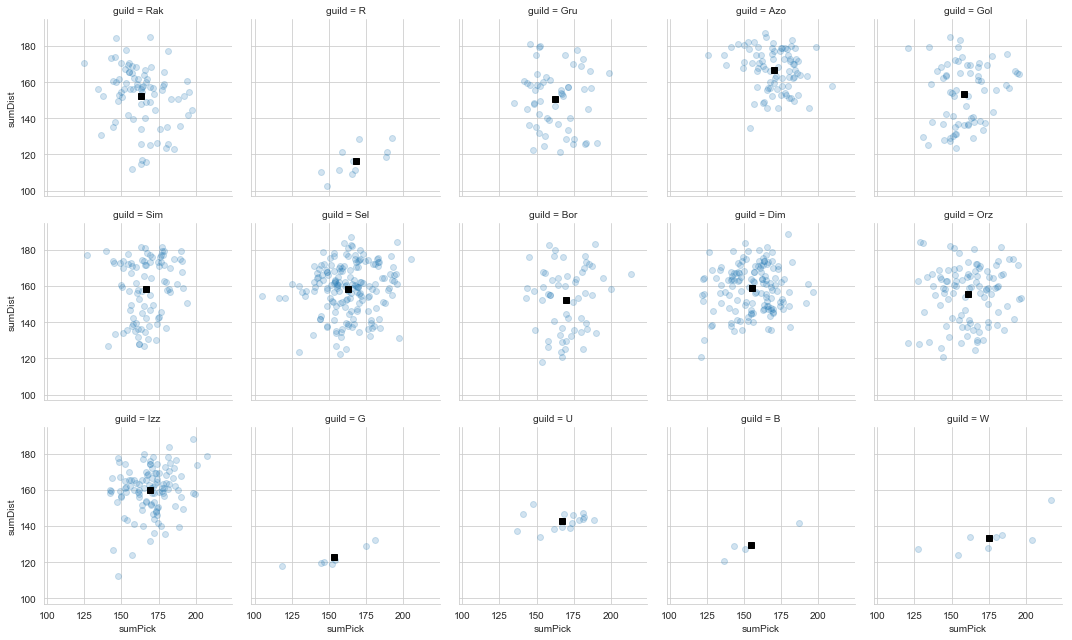

In [137]:
# Plot everything:

#myPal = sns.xkcd_palette(["gold","deep blue","black","red","green","lavender","grey"])

sns.set_style("whitegrid")
g = sns.FacetGrid(dataToPlot, col="guild", col_wrap = 5, aspect = 1)
s = g.map(plt.scatter,"sumPick","sumDist",alpha=0.2)#,palette=myPal)
#s.fig.set_size_inches(7,6)
#s.despine(left=True,bottom=True)
#s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

def mean_point(x,y, **kwargs):
    plt.plot(x.mean(), y.mean(),'ks')
    #plt.text(x.mean()+1, 0.052, 'mean = '+str('%.2f'%x.mean()), size=12)
    #plt.text(x.mean()+1, 0.0455, 'std = '+str('%.2f'%x.std()), size=12)

g.map(mean_point, 'sumPick' , 'sumDist');

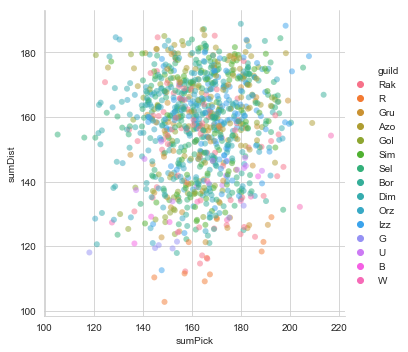

In [138]:
# All in one plot

sns.set_style("whitegrid")
s = sns.relplot(data=dataToPlot, x='sumPick', y='sumDist', hue='guild',
                alpha=0.5, edgecolor='none')

# Not very helpful because of colors, and it's hard to come up with good colors here.
# Also the sequence of guilds is arbitrary (the order in which they were met in the data), which doesn't help coloring them.

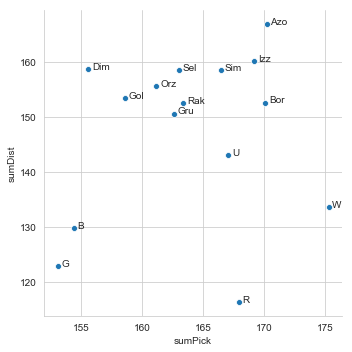

In [139]:
sumData = dataToPlot.groupby('guild').mean()

p1 = sns.relplot(data=sumData, x='sumPick', y='sumDist')

for iline in range(0,sumData.shape[0]):
    p1.axes[0,0].text(sumData['sumPick'][iline]+0.3, sumData['sumDist'][iline], sumData.index.values.tolist()[iline])

In [140]:
# Short helper function to better visualize hands

def showHand(hand):
    hand = fixName(hand).lower().split(',')
    return pd.DataFrame({'color': [''.join(thisSet[card]['colorIdentity']) for card in list(hand)],
                         'rank' : [df.loc[fix_gates(card)]['avg'] for card in list(hand)]},
                        list(hand))

# Oddly ''.join() works like a charm: ''.join(thisSet[hand[0]]['colorIdentity'])

     ind     sumPick     sumDist guild     w    u    b     r    g
431  431  143.714742  159.148544   Bor   9.0  0.0  0.0  15.0  0.0
352  352  190.130958  133.952756   Bor  23.0  0.0  0.0   1.0  0.0
253  253  180.945600  124.951277   Bor   1.0  0.0  0.0  23.0  0.0
702  702  158.603844  182.799261   Bor  10.0  4.0  2.0   7.0  0.0


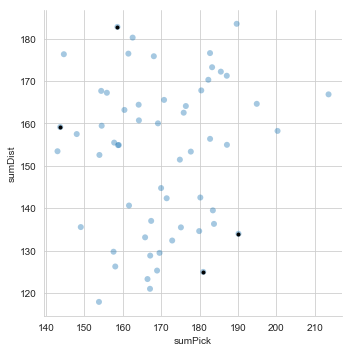

ilharg_the_raze-boar, ignite_the_beacon, jaya_venerated_firemage, herald_of_the_dreadhorde, nahiri's_stoneblades, raging_kronch, goblin_assault_team, blindblast, heartwarming_redemption, burning_prophet, bond_of_passion, sarkhan's_catharsis, crush_dissent, ironclad_krovod, divine_arrow, tenth_district_legionnaire, war_screecher, chandra's_pyrohelix, jaya_venerated_firemage, tenth_district_legionnaire, battlefield_promotion, heartfire, goblin_assault_team, ahn-crop_invader, spellgorger_weird, goblin_assault_team, spellgorger_weird, kaya's_ghostform, ugin_the_ineffable, nahiri's_stoneblades, dreadhorde_twins, battlefield_promotion, samut's_sprint, enforcer_griffin, feather_the_redeemed, time_wipe, feather_the_redeemed, goblin_assault_team, teferi_time_raveler, arboreal_grazer, goblin_assailant, contentious_plan
['R', 'W', 'R', 'B', 'R', 'R', 'R', 'R', 'Multi', 'R', 'R', 'R', 'U', 'W', 'W', 'Multi', 'W', 'R', 'R', 'Multi', 'W', 'R', 'R', 'R', 'R', 'R', 'R', 'B', 'C', 'R', 'R', 'W', 'R', '

In [158]:
# Look at some extreme decks (worst, best, etc)

%matplotlib inline

localData = dataToPlot.loc[dataToPlot['guild']=='Bor']

# Find some interesting points, with neutral values on one axis, and extreme values of another
indLeft   = localData.index[localData['sumPick']==min(localData['sumPick'][localData['sumDist']>np.median(localData['sumDist'])])][0]
indRight  = localData.index[localData['sumPick']==max(localData['sumPick'][localData['sumDist']<np.median(localData['sumDist'])])][0]
indBottom = localData.index[localData['sumDist']==min(localData['sumDist'][localData['sumPick']>np.median(localData['sumPick'])])][0]
indTop    = localData.index[localData['sumDist']==max(localData['sumDist'][localData['sumPick']<np.median(localData['sumPick'])])][0]

extremePointsInd = [indLeft, indRight, indBottom, indTop]

print(localData.loc[extremePointsInd])

sns.relplot(data=localData, x='sumPick', y='sumDist', edgecolor='none', alpha=0.4);
plt.plot(localData.loc[extremePointsInd]['sumPick'],localData.loc[extremePointsInd]['sumDist'],'k.')
plt.show() # For the plot to stay above the text

# Look at any of these 4 extreme decks. First as a simple list:
print(fixName(draftData[playerName].iloc[indBottom]).replace(",",", "))
print(df.loc[fixName(draftData[playerName].iloc[indBottom]).lower().split(',')]['color'].tolist())

# Then as an annoted column of data:
# print(showHand(draftData[playerName].iloc[indLeft]))


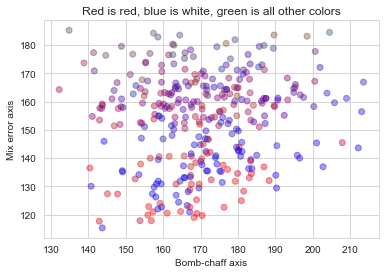

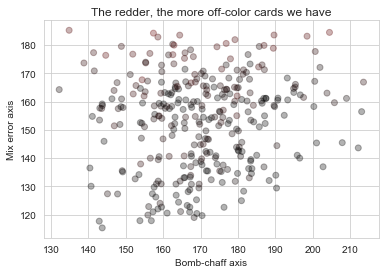

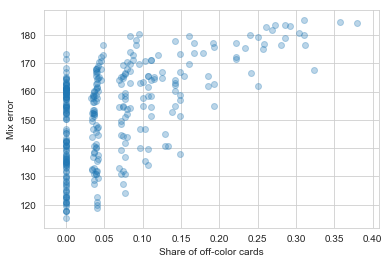

In [114]:
# Look at 2 color vs 3 color decks

%matplotlib inline

localData = dataToPlot.loc[dataToPlot['guild']=='Bor']

# Let's calculate dot colors from color identities. 
# Now, as a card can have more than 1 color identity, this calculation is a bit weird.
rgbthing = np.zeros((len(localData),3))
temp = np.array(localData[['r','w']].values) # Number of in-color card, but dual-colors are double-counted
rgbthing[:,0] = temp[:,0]/np.sum(np.array(localData[colorList]),1) # Ratio to the full number of identities
rgbthing[:,2] = temp[:,1]/np.sum(np.array(localData[colorList]),1)
# The above calculation is weird. If 50% of cards are red, and 50% are black, it gives 50% red deck.
# But if 50% of cards are WR duals, and 50% are black, it gives 33% red, 33% white, 33% black deck.
# Which is not incorrect (what would be "correct" here???), but it IS weird.
rgbthing[:,1] = 1-np.sum(rgbthing,1)

#print(rgbthing[:10,:])

#sns.relplot(data=localData, x='sumPick', y='sumDist', edgecolor='none', alpha=0.4);
plt.scatter(localData['sumPick'], localData['sumDist'], c=rgbthing, alpha=0.4)
plt.title('Red is red, blue is white, green is all other colors');
plt.xlabel('Bomb-chaff axis');
plt.ylabel('Mix error axis');
plt.show()

#n = len(localData)
#plt.scatter(localData['sumPick'], localData['sumDist'], 
#            c=np.concatenate((np.zeros((n,3)),rgbthing[:,1].reshape(-1,1)),1))
# Three weird things here: 
# one is that the only way to set alpha is communicate it as the 4th (j=3) column in rgb.
# Another, is that slicing a column from a matrix makes it a vector, and vectors are rows, so had to reshape before concat.
# Finanlly, in reshaping, -1 signifies default dim that is calculated based on the length and other dim.
#plt.title('Share of off-color cards');
# (I ended up not liking this plot, as alpha is confusing with so many points)

n = len(localData)
plt.scatter(localData['sumPick'], localData['sumDist'], alpha=0.3,
            c=np.concatenate((rgbthing[:,1].reshape(-1,1),np.zeros((n,2))),1))
plt.title('The redder, the more off-color cards we have');
plt.xlabel('Bomb-chaff axis');
plt.ylabel('Mix error axis');
plt.show()

# A more obvious statement: the more off-color, the lower the synergy
plt.scatter(rgbthing[:,1], localData['sumDist'], alpha=0.3);
plt.xlabel('Share of off-color cards');
plt.ylabel('Mix error');

### Next steps:

First priority:

* ~~Sensitivity: same, but for bot drafts~~
* ~~Compare bots to humans directly?~~
* ~~GRN~~
* ~~Look at individual decks at extremes: best deck, wost, most synergistic, most bomby~~
* ~~Run same analysis, but after selecting 25 best cards from each pile (ignore the off-strategy picks)~~

Second priority:

* Color contributions
* Put in perspective: add random decks and "ideal decks" on the same plot

Third priority:

* Simple Bot (fixed synergy / rating ratio across draft), % of match with humans
* Simple Bot, % of match with Dan bots (current draftsim)
* Compare average bot-drafted deck across guilds


# Direct comparison of bots to humans

In [29]:
# Direct comparison of bots to humans
#
# I am ashamed to confess that this module only works if you first run everything above for humans, 
# run this cell, then run everything for bots, and run this cell again. Then run next cell.

if playerName=='human':
    humanData = dataToPlot.copy()
    print('Human rewritten, bot preserved')
else:
    botData = dataToPlot.copy()
    print('Bot rewritten, human preserved')

Bot rewritten, human preserved


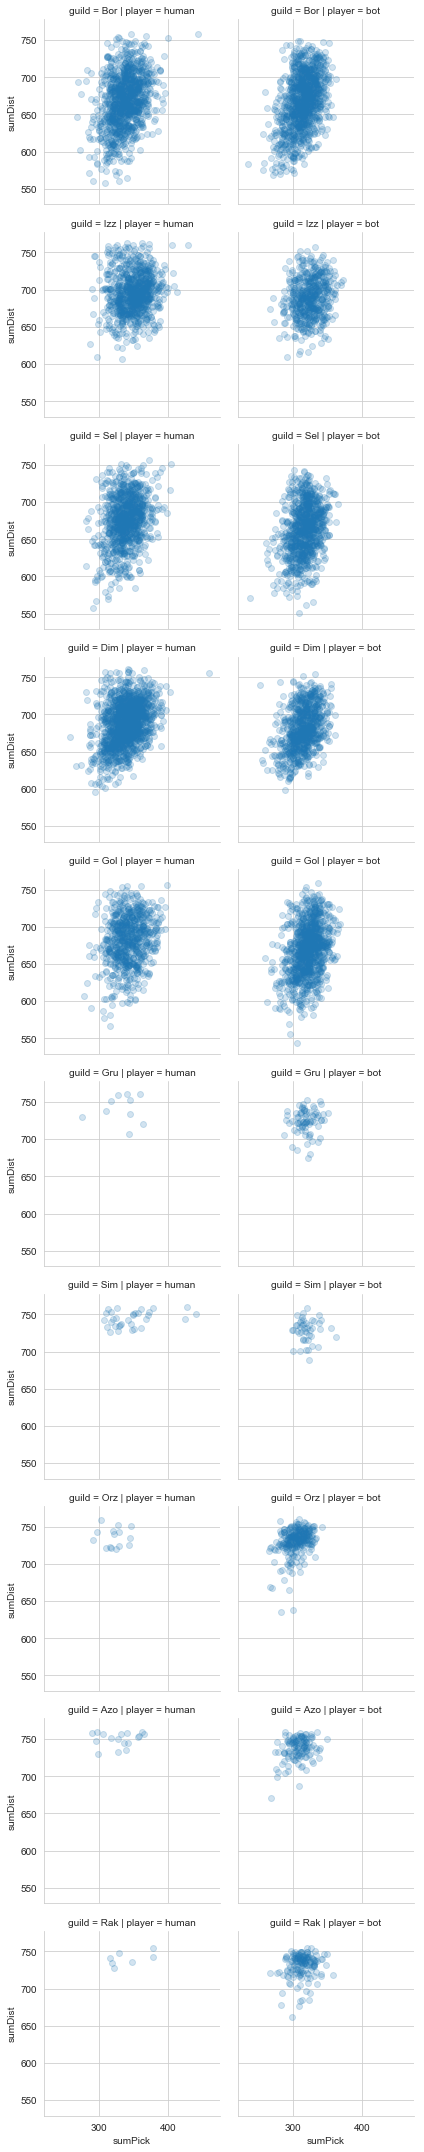

In [30]:
# Combine human and bot data and plot them.
    
tempH = humanData
tempH['player'] = 'human'

tempB = botData
tempB['player'] = 'bot'

fullSet = pd.concat([tempH,tempB],axis=0)

#fullSet['player'].unique()

sns.set_style("whitegrid")
g = sns.FacetGrid(fullSet, col="player", row="guild", aspect = 1)
s = g.map(plt.scatter,"sumPick","sumDist",alpha=0.2)#,palette=myPal)

